<a href="https://colab.research.google.com/github/adhiraj4ai/Stock-Prediction---NEPSE/blob/main/Stock%20Market%20Prediction%20for%20NEPSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

import math
import string
import pandas as pd
import numpy as np

# Import Scaler
from sklearn.preprocessing import StandardScaler

# Import visual library
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Mount the google drive 
from google.colab import drive
drive.mount('/content/drive')

# File is in google drive
file_path = "/content/drive/MyDrive/Colab Notebooks/NEPSE/data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read csv file from data.csv file
nepse_df = pd.read_csv(file_path, header = 0)

## Data Preprocessing

In [ ]:
# Check the data in the top of the dataframe
nepse_df.head()

,Symbol,Date,Open,High,Low,Close,Percent Change,Volume
0,API,15/07/2022,250.0,250.0,240.7,244.5,-2.20,96160
1,API,14/07/2022,256.0,258.0,247.0,250.0,-0.40,75180
2,API,13/07/2022,243.0,251.9,240.0,251.0,4.58,100815
3,API,12/07/2022,240.0,249.0,233.3,240.0,0.84,91642
4,API,11/07/2022,245.0,245.0,236.0,238.0,-4.80,120708


In [ ]:
# Drop date from the dataframe and set as index
nepse_df.set_index('Date', drop=True, inplace = True)

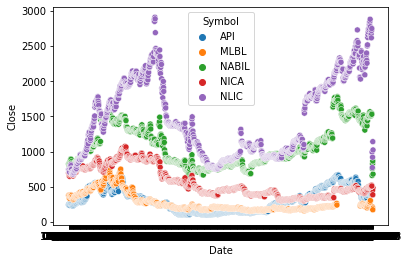

In [ ]:
# Plot the Scatterplot for all scrip
sns.scatterplot(data = nepse_df, x = "Date", y = "Close", hue="Symbol")

Our data consists a data for only five scrip. 

In [ ]:
# Check of null or missing data
nepse_df.isnull().sum()

Symbol            0
Open              0
High              0
Low               0
Close             0
Percent Change    0
Volume            0
dtype: int64

## Build RNN Model

In [ ]:
# Define the RNN Model
rnn_model = keras.Sequential([
                          layers.SimpleRNN(units = 100, return_sequences=True),
                          layers.Dropout(0.2),
                          layers.SimpleRNN(units = 75, return_sequences = False),
                          layers.Dropout(0.2),
                          layers.Dense(units = 20),
                          layers.Dense(units = 1)
])

rnn_model.compile(optimizer = 'adam', loss = tf.losses.mean_squared_error, metrics = ['mean_absolute_error'])

## Build LSTM Model

In [ ]:
# Define the LSTM Model
lstm_model = keras.Sequential([
                          layers.LSTM(units = 100, return_sequences=True),
                          layers.Dropout(0.2),
                          layers.LSTM(units = 75, return_sequences = False),
                          layers.Dropout(0.2),
                          layers.Dense(units = 20),
                          layers.Dense(units = 1)
])

lstm_model.compile(optimizer = 'adam', loss = tf.losses.mean_squared_error, metrics = ['mean_absolute_error'])

## Define the plot functions

In [ ]:
def plot_loss(history):
    """
        Plot function for training and validation loss per epoch
    """
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

def plot_prediction(df, predictions, training_data_len):
    """
        Plot function for predicted outcome
    """
    data = df.filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predictions'] = predictions
    plt.figure(figsize=(10,6))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predictions']])
    plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
    plt.show()

In [ ]:
def predict(model, x_test, scaler):
    """
        Predict function for prediction on test data
    """
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions


def RMSE(predictions, y_test):
    """
        RMSE Error
    ""
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return rmse

## Train the model
Here we train the model for all scrip in loop.

In [ ]:
def train_model(model_name, model, data, x_train, y_train, x_test, y_test, scaler, training_data_len, epochs = 10):
    """
        Function to train model
    """
  history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.1, verbose = 0)
  predictions = predict(model, x_test, scaler)

  print(model_name)
  print("------------------------------")
  print("RMSE is", RMSE(predictions, y_test))
  # Plot loss and prediction for RNN
  print("\n\nLoss Plot")
  plot_loss(history)
  print("\n\nTraining vs Validation vs Testing Plot")
  plot_prediction(data, predictions, training_data_len)

In [ ]:
def train_for(scrip, data):
  print("Executing training for", scrip)
  print("----------------------------------------")
  data = data[data['Symbol'] == scrip]
  close_prices = data['Close']
  values = close_prices.values
  training_data_len = math.ceil(len(values)* 0.8)

  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(values.reshape(-1, 1))

  # For Training Data
  train_data = scaled_data[0: training_data_len, :]

  epochs = 50
  window_size = 5

  x_train = []
  y_train = []

  # Create a window for the prediction dependency
  for i in range(window_size, len(train_data)):
      x_train.append(train_data[i-window_size:i, 0])
      y_train.append(train_data[i, 0])
      
  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  # For Test data
  test_data = scaled_data[training_data_len-window_size: , : ]
  x_test = []
  y_test = values[training_data_len:]

  # Create a window for the prediction dependency
  for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  train_model("RNN", rnn_model, data, x_train, y_train, x_test, y_test, scaler, training_data_len, epochs)

  train_model("LSTM", lstm_model, data, x_train, y_train, x_test, y_test, scaler, training_data_len, epochs)

## API

Executing training for API
----------------------------------------
RNN
------------------------------
RMSE is 9.082581414116753


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


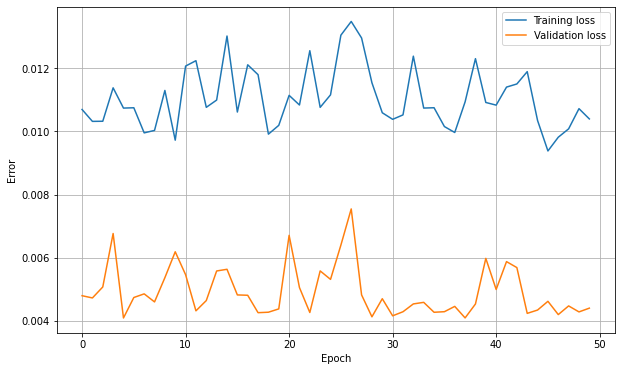

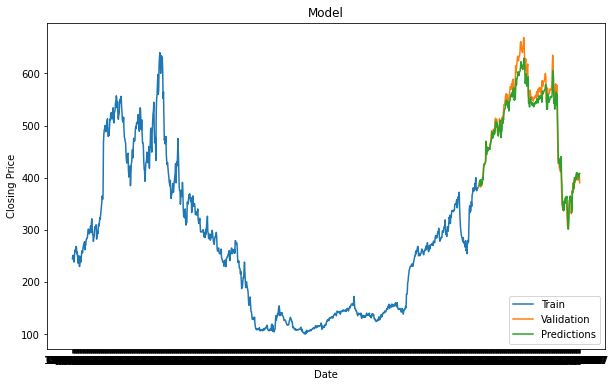

LSTM
------------------------------
RMSE is 6.74041263640873


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


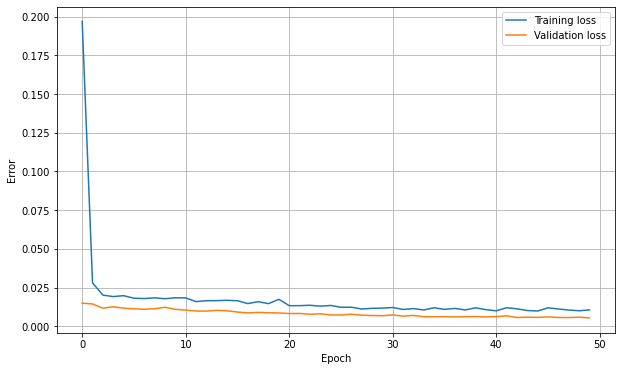

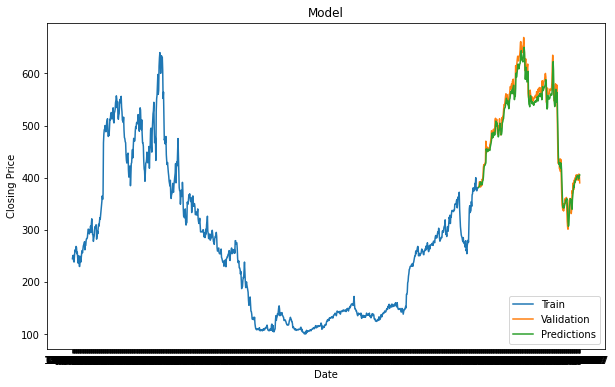

In [ ]:
train_for("API", nepse_df)

# MLBL

Executing training for MLBL
----------------------------------------
RNN
------------------------------
RMSE is 2.4660107185100686


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


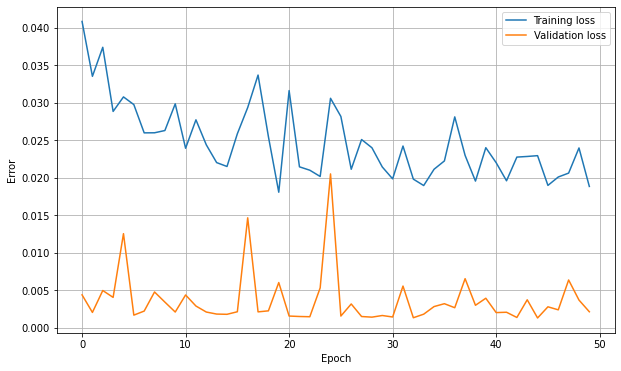

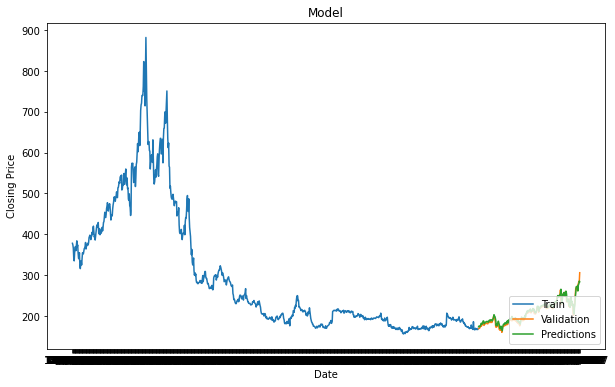

LSTM
------------------------------
RMSE is 1.5075759229988888


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


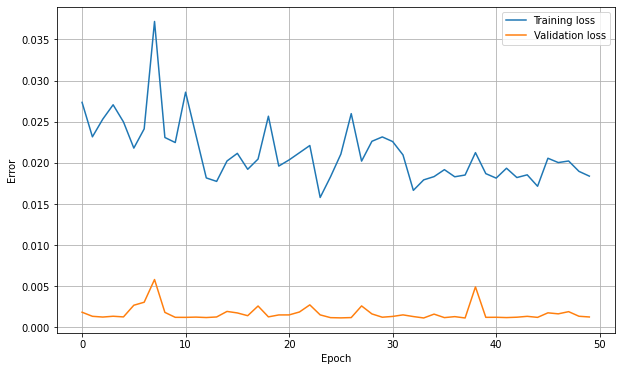

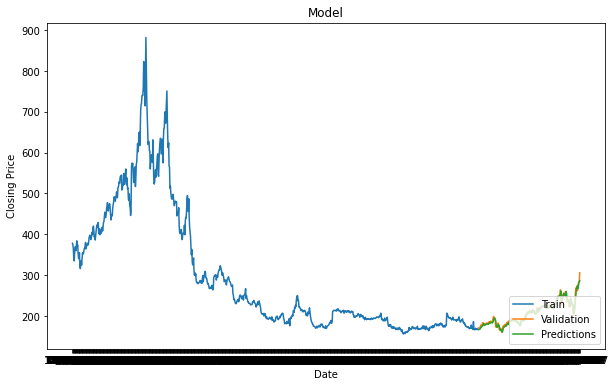

In [ ]:
train_for("MLBL", nepse_df)

## NHPC

Executing training for NABIL
----------------------------------------
RNN
------------------------------
RMSE is 16.652599031963046


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


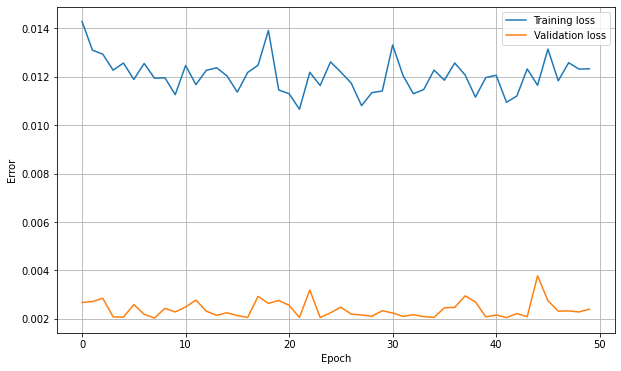

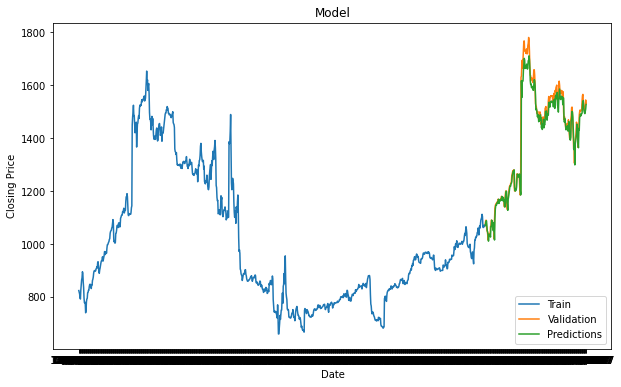

LSTM
------------------------------
RMSE is 9.44564480251736


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


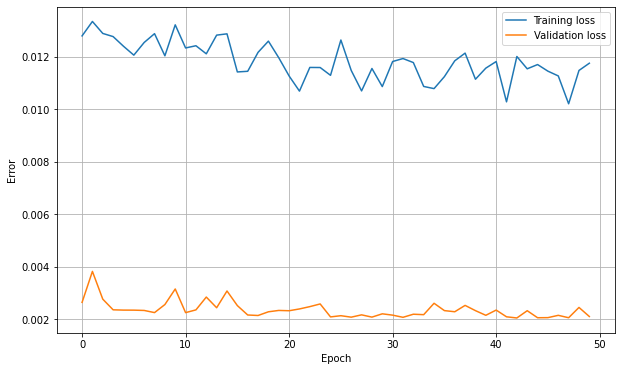

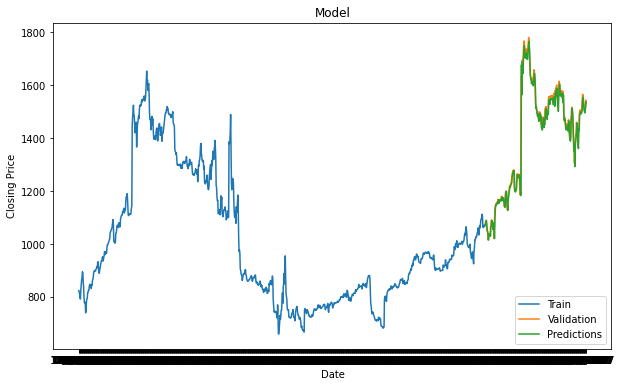

In [ ]:
train_for("NABIL", nepse_df)

## NICA

Executing training for NICA
----------------------------------------
RNN
------------------------------
RMSE is 1.6912818878535696


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


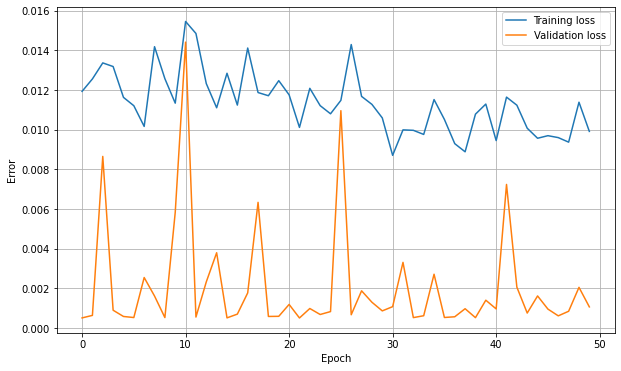

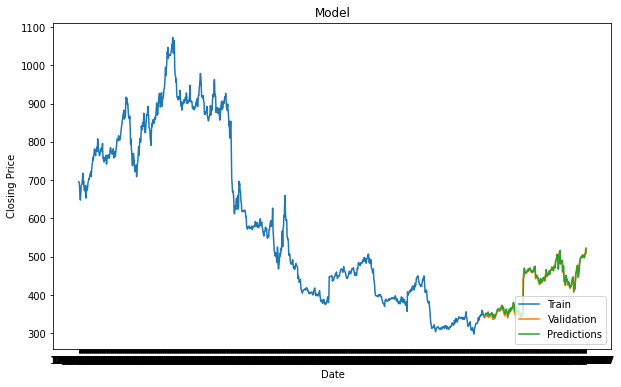

LSTM
------------------------------
RMSE is 4.390921370314044


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


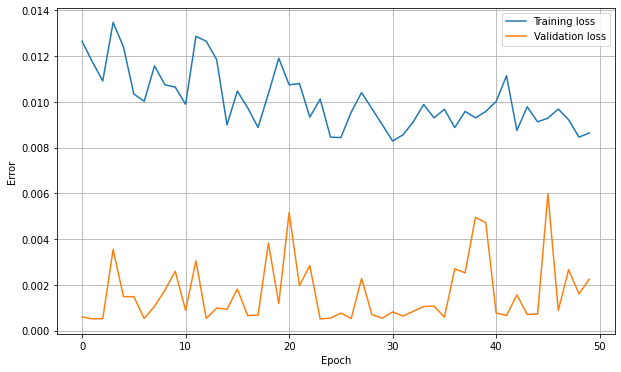

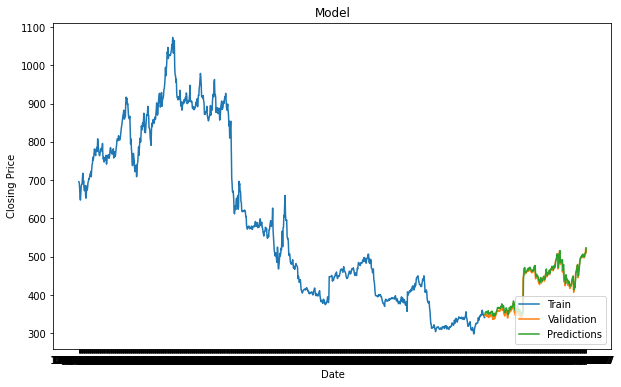

In [ ]:
train_for("NICA", nepse_df)

## NLIC

Executing training for NLIC
----------------------------------------
RNN
------------------------------
RMSE is 2.018334671442688


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


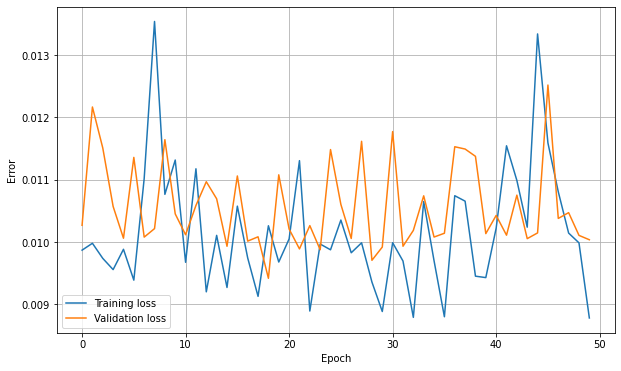

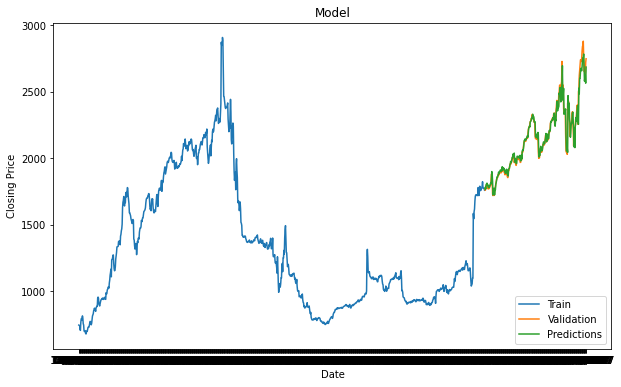

LSTM
------------------------------
RMSE is 31.24055667922431


Loss Plot


Training vs Validation vs Testing Plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


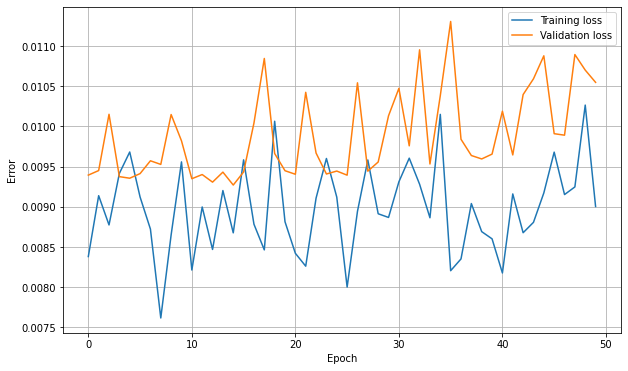

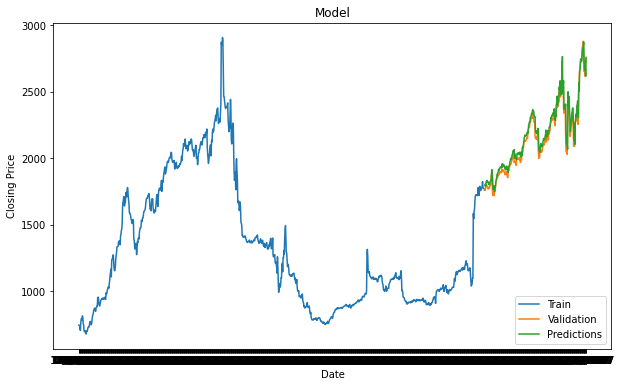

In [ ]:
train_for("NLIC", nepse_df)

**Conclusion:** For Some SCRIP RNN has worked better and for some SCRIP LSTM has worked better.